# ADS 509 Module 3: Group Comparison 

The task of comparing two groups of text is fundamental to textual analysis. There are innumerable applications: survey respondents from different segments of customers, speeches by different political parties, words used in Tweets by different constituencies, etc. In this assignment you will build code to effect comparisons between groups of text data, using the ideas learned in reading and lecture.

This assignment asks you to analyze the lyrics and Twitter descriptions for the two artists you selected in Module 1. If the results from that pull were not to your liking, you are welcome to use the zipped data from the “Assignment Materials” section. Specifically, you are asked to do the following: 

* Read in the data, normalize the text, and tokenize it. When you tokenize your Twitter descriptions, keep hashtags and emojis in your token set. 
* Calculate descriptive statistics on the two sets of lyrics and compare the results. 
* For each of the four corpora, find the words that are unique to that corpus. 
* Build word clouds for all four corpora. 

Each one of the analyses has a section dedicated to it below. Before beginning the analysis there is a section for you to read in the data and do your cleaning (tokenization and normalization). 


## General Assignment Instructions

These instructions are included in every assignment, to remind you of the coding standards for the class. Feel free to delete this cell after reading it. 

One sign of mature code is conforming to a style guide. We recommend the [Google Python Style Guide](https://google.github.io/styleguide/pyguide.html). If you use a different style guide, please include a cell with a link. 

Your code should be relatively easy-to-read, sensibly commented, and clean. Writing code is a messy process, so please be sure to edit your final submission. Remove any cells that are not needed or parts of cells that contain unnecessary code. Remove inessential `import` statements and make sure that all such statements are moved into the designated cell. 

Make use of non-code cells for written commentary. These cells should be grammatical and clearly written. In some of these cells you will have questions to answer. The questions will be marked by a "Q:" and will have a corresponding "A:" spot for you. *Make sure to answer every question marked with a `Q:` for full credit.* 


In [161]:
# Use this space for any additional import statements you need
import warnings

warnings.filterwarnings('ignore')

In [162]:
import os
import re
import emoji
import pandas as pd

from collections import Counter, defaultdict
from nltk.corpus import stopwords
from string import punctuation
from wordcloud import WordCloud 

from sklearn.feature_extraction.text import TfidfTransformer, CountVectorizer

In [163]:
# Place any addtional functions or constants you need here. 

# Some punctuation variations
punctuation = set(punctuation) # speeds up comparison
tw_punct = punctuation - {"#"}

# Stopwords
sw = stopwords.words("english")

# Two useful regex
whitespace_pattern = re.compile(r"\s+")
hashtag_pattern = re.compile(r"^#[0-9a-zA-Z]+")

# It's handy to have a full set of emojis
all_language_emojis = set()

for country in emoji.UNICODE_EMOJI : 
    for em in emoji.UNICODE_EMOJI[country] : 
        all_language_emojis.add(em)

# and now our functions
def descriptive_stats(tokens, num_tokens = 5, verbose=True) :
    """
        Given a list of tokens, print number of tokens, number of unique tokens, 
        number of characters, lexical diversity (https://en.wikipedia.org/wiki/Lexical_diversity), 
        and num_tokens most common tokens. Return a list with the number of tokens, number
        of unique tokens, lexical diversity, and number of characters. 
    
    """

    # Fill in the correct values here. 
    num_tokens = len(tokens)
    num_unique_tokens = len(set(tokens))
    lexical_diversity = num_unique_tokens/num_tokens
    num_characters = sum([len(x) for x in tokens])
    
    if verbose :        
        print(f"There are {num_tokens} tokens in the data.")
        print(f"There are {num_unique_tokens} unique tokens in the data.")
        print(f"There are {num_characters} characters in the data.")
        print(f"The lexical diversity is {lexical_diversity:.3f} in the data.")
    
        
    return([num_tokens, num_unique_tokens,
            lexical_diversity,
            num_characters])
    
    
def is_emoji(s):
    return(s in all_language_emojis)

def contains_emoji(s):
    
    s = str(s)
    emojis = [ch for ch in s if is_emoji(ch)]

    return(len(emojis) > 0)


def remove_stop(tokens) :
    # modify this function to remove stopwords
    return([x for x in tokens if x not in sw])
 
def remove_punctuation(text, punct_set=tw_punct) : 
    return("".join([ch for ch in text if ch not in punct_set]))

def tokenize(text) : 
    """ Splitting on whitespace rather than the book's tokenize function. That 
        function will drop tokens like '#hashtag' or '2A', which we need for Twitter. """
    
    # modify this function to return tokens
    text = re.sub(r'\s{2,}', ' ', text)
    return(text.split(' '))

def prepare(text, pipeline) : 
    tokens = str(text)
    
    for transform in pipeline : 
        tokens = transform(tokens)
        
    return(tokens)


## Data Ingestion

Use this section to ingest your data into the data structures you plan to use. Typically this will be a dictionary or a pandas DataFrame.

In [187]:
# Feel fre to use the below cells as an example or read in the data in a way you prefer

data_location = "" # change to your location if it is not in the same directory as your notebook
twitter_folder = "twitter/"
lyrics_folder = "lyrics/"

artist_files = {'eminem':'EmiNeM_follower_data.txt',
                'snoop':'SnoopDogg_follower_data.txt'}

In [188]:
twitter_data = pd.read_csv(data_location + twitter_folder + artist_files['eminem'],
                           sep="\t",
                           quoting=3)

twitter_data['artist'] = "eminem"

In [189]:
twitter_data_2 = pd.read_csv(data_location + twitter_folder + artist_files['snoop'],
                             sep="\t",
                             quoting=3)
twitter_data_2['artist'] = "snoop"

twitter_data = pd.concat([
    twitter_data,twitter_data_2])
    
del(twitter_data_2)

In [190]:
# As an extra step just for twitter_data, drop any row with empty description
print('Current Twitter shape is {}'.format(twitter_data.shape))
twitter_data = twitter_data[~twitter_data['description'].isna()]
twitter_data.reset_index(drop=True, inplace=True)
print('After dropping, Twitter shape is {}'.format(twitter_data.shape))

Current Twitter shape is (139289, 8)
After dropping, Twitter shape is (71962, 8)


In [191]:
# read in the lyrics here

In [192]:
artists = ['eminem', 'snoop']

lyrics_data = pd.DataFrame(columns=['artist', 'title', 'lyrics'])

for artist in artists:
    
    path = os.path.join(data_location, lyrics_folder, artist)
    
    for file in os.listdir(path):
        
        if 'txt' not in file:
            continue
            
        song_path = os.path.join(path, file)
        
        with open(song_path, 'r') as file:
            song = file.readlines()
            
        title = song[0].replace('\n', '').strip()
        
        lyric = song[1:]
        lyric = ' '.join(lyric)
        lyric = lyric.replace('\n', '').strip()
        
        lyrics_data = pd.concat([lyrics_data, pd.DataFrame({
                                        'artist':artist,
                                        'title':title,
                                        'lyrics':lyric
                                    }, index=[0])], ignore_index=True)

In [193]:
twitter_data.shape, lyrics_data.shape

((71962, 8), (454, 3))

## Tokenization and Normalization

In this next section, tokenize and normalize your data. We recommend the following cleaning. 

**Lyrics** 

* Remove song titles
* Casefold to lowercase
* Remove punctuation
* Split on whitespace
* Remove stopwords (optional)

Removal of stopwords is up to you. Your descriptive statistic comparison will be different if you include stopwords, though TF-IDF should still find interesting features for you.

**Twitter Descriptions** 

* Casefold to lowercase
* Remove punctuation other than emojis or hashtags
* Split on whitespace
* Remove stopwords

Removing stopwords seems sensible for the Twitter description data. Remember to leave in emojis and hashtags, since you analyze those. 

In [194]:
lyrics_data.head()

,artist,title,lyrics
0,eminem,Rap God,"Look, I was gonna go easy on you not to hurt y..."
1,eminem,Hellbound (H&H Remix),"Welcome back to the stage of history (Yo, Sli..."
2,eminem,Infinite,"Aw, yeah (It's like this, like this) It's Emin..."
3,eminem,So Bad,"Yeah, haha, you feel that, baby? Yeah, I feel ..."
4,eminem,The King And I,"It goes: one for the trailer park, two for my ..."


In [196]:
twitter_data.tail()

,screen_name,name,id,location,followers_count,friends_count,description,artist
71957,Mat_Genius,Mathews Zuku,1.527574e+18,NaN,0.0,58.0,Peace maker,snoop
71958,PNzungulu,Patrio Nzungulu,1.527578e+18,NaN,0.0,49.0,𝑳𝒐𝒗𝒆,snoop
71959,buduzere,Buduzere,1.525987e+18,NaN,0.0,57.0,Living my best life,snoop
71960,njosh_jon,Jon Njosh,1.520304e+18,NaN,0.0,87.0,Fashionister,snoop
71961,sombre_symphony,Sombre_symphony,1.527164e+18,NaN,23.0,170.0,«I was looking for love and found myself»,snoop


In [197]:
# apply the `pipeline` techniques from BTAP Ch 1 or 5

my_pipeline = [str.lower, remove_punctuation, tokenize, remove_stop]

lyrics_data["tokens"] = lyrics_data["lyrics"].apply(prepare,pipeline=my_pipeline)
lyrics_data["num_tokens"] = lyrics_data["tokens"].map(len) 

twitter_data["tokens"] = twitter_data["description"].apply(prepare,pipeline=my_pipeline)
twitter_data["num_tokens"] = twitter_data["tokens"].map(len) 

In [198]:
twitter_data['has_emoji'] = twitter_data["description"].apply(contains_emoji)

Let's take a quick look at some descriptions with emojis.

In [199]:
twitter_data[twitter_data.has_emoji].sample(10)[["artist","description","tokens"]]

,artist,description,tokens
32543,eminem,i like cars | 🇺🇸 🇨🇺 ♍️ 🌈,"[like, cars, 🇺🇸, 🇨🇺, ♍️, 🌈]"
2258,eminem,“In My Head” OUT NOW 🖤,"[“in, head”, 🖤]"
38887,snoop,🍄4₿₿₿ | Psychedelics Anonymous🚀 | Non-Fungible...,"[🍄4₿₿₿, psychedelics, anonymous🚀, nonfungible,..."
23698,eminem,If it ain’t lifted it ain’t gifted ya’ll😉,"[ain’t, lifted, ain’t, gifted, ya’ll😉]"
22682,eminem,Aisyah 🥰,"[aisyah, 🥰]"
40979,snoop,"keep it simple, babe 💃🏻","[keep, simple, babe, 💃🏻]"
69604,snoop,🙏Guided by God 🙏,"[🙏guided, god, 🙏]"
20388,eminem,Muslim and proud🙌🏽🙏🏾,"[muslim, proud🙌🏽🙏🏾]"
31205,eminem,Fan Page with all content related to GANZI. 🔌🎧...,"[fan, page, content, related, ganzi, 🔌🎧🔥, ewf,..."
32823,eminem,19 l broista l 🏀 🏀 l Gemini. @elmstreetproam,"[19, l, broista, l, 🏀, 🏀, l, gemini, elmstreet..."


With the data processed, we can now start work on the assignment questions. 

Q: What is one area of improvement to your tokenization that you could theoretically carry out? (No need to actually do it; let's not make perfect the enemy of good enough.)

A: One thing that can be done is to modify some portion of dropping stop words. This was discussed and addressed last week but it's possible to have less accurate data (or results) if we drop all stop words. Instead after some manual labor, we can create a list of stopwords that are safe to drop without comprimising the accuracy. For example, in most cases, we add "s" at the end of a word if it is plural with "A" before the word like A plane -> Planes. This is soley for grammatical purpose so we can agree to drop words like "a" or "an".

Also another possible way of preprocessing is dropping any word that only appears once throughout the whole dataset. Assuming there are total of 1,000,000 words (non-unique) in a dataframe, it's possible there are some words appear only once. This could be due to typo or a word is rarely used actually that we can't find much usefulness when analyzing semantics of tweets. For example with previous assignment for determining if a sentence is positive or negative, if there appears a word only once, we cannot clearly determine if the word has positive or negative impact to the semantic. (Just noticed that this is addressed in a similar manner below with using n)

## Calculate descriptive statistics on the two sets of lyrics and compare the results. 


In [200]:
for artist in artists:
    
    temp = lyrics_data[lyrics_data['artist']==artist]['tokens']
    
    print(artist, '{} songs'.format(temp.shape[0]))
    print()
    tokens = []
    [tokens.extend(x) for x in temp]
    descriptive_stats(tokens)
    print()
    print()

eminem 389 songs

There are 157835 tokens in the data.
There are 17264 unique tokens in the data.
There are 781337 characters in the data.
The lexical diversity is 0.109 in the data.


snoop 65 songs

There are 20797 tokens in the data.
There are 4221 unique tokens in the data.
There are 99299 characters in the data.
The lexical diversity is 0.203 in the data.




Q: what observations do you make about these data? 

A: 


## Find tokens uniquely related to a corpus

Typically we would use TF-IDF to find unique tokens in documents. Unfortunately, we either have too few documents, if we view each data source as a single document, or too many, if we view each description as a separate document. In the latter case, our problem will be that descriptions tend to be short, so our matrix would be too sparse to support analysis. 

To get around this, we find tokens for each corpus that match the following criteria:

1. The token appears at least `n` times in all corpora
1. The tokens are in the top 10 for the highest ratio of appearances in a given corpora vs appearances in other corpora.

You will choose a cutoff for yourself based on the side of the corpus you're working with. If you're working with the Robyn-Cher corpora provided, `n=5` seems to perform reasonably well.


In [208]:
def calculate_ratio(corpora, min_count=3, name='ratio'):
    
    # Get a list of tokens
    tokens = []
    [tokens.extend(x) for x in corpora]
    
    total, _, _, _ = descriptive_stats(tokens, verbose=False)
    
    # corpora is a list of list of tokens so combine them into list of string
    corpora = corpora.str.join(' ')
    
    # count number of tokens showing up at least min_count
    vectorizer = CountVectorizer(min_df=min_count)
    
    ratio = vectorizer.fit_transform(corpora)
    
    # Count sum of word's appearance
    ratio = pd.DataFrame(ratio.toarray().sum(axis=0), index=vectorizer.get_feature_names(), columns=[name])
    
    # Get the ratio of appearance for each word
    ratio = ratio / total
    
    # Sort by ratio in descending order
    ratio = ratio.sort_values(name, ascending=False)

    return ratio

In [209]:
artist1_twitter = calculate_ratio(twitter_data[twitter_data['artist']==artists[0]]['tokens'], name='eminem_twitter')
artist1_lyric = calculate_ratio(lyrics_data[lyrics_data['artist']==artists[0]]['tokens'], name='eminem_lyric')

artist2_twitter = calculate_ratio(twitter_data[twitter_data['artist']==artists[1]]['tokens'], name='snoop_twitter')
artist2_lyric = calculate_ratio(lyrics_data[lyrics_data['artist']==artists[1]]['tokens'], name='snoop_lyric')

In [211]:
# Top 10 tokens for each corpora

artist1_twitter.head(10)

,eminem_twitter
love,0.006910
im,0.006546
life,0.006020
de,0.005691
music,0.005009
fan,0.004090
like,0.003819
la,0.003195
god,0.002912
artist,0.002675


In [213]:
artist1_lyric.head(10)

,eminem_lyric
im,0.025710
like,0.016162
dont,0.011702
get,0.010942
cause,0.009808
got,0.007850
shit,0.007400
know,0.006874
back,0.006760
aint,0.006456


In [214]:
artist2_twitter.head(10)

,snoop_twitter
nft,0.011943
love,0.008507
im,0.006917
life,0.006609
artist,0.005974
crypto,0.005631
music,0.004128
nfts,0.003830
like,0.003504
god,0.002996


In [215]:
artist2_lyric.head(10)

,snoop_lyric
im,0.020820
nigga,0.016060
get,0.014858
dogg,0.012021
niggas,0.011444
like,0.010963
dont,0.010578
got,0.010290
shit,0.010194
snoop,0.010001


In [261]:
# Now check each corpora's top 10 words against other three
corporas = [artist1_twitter, artist1_lyric, artist2_twitter, artist2_lyric]

for corpora in corporas:
    
    top_10 = corpora.head(10)
    artist = top_10.columns[0].upper().split('_')[0]
    corp_name = top_10.columns[0].upper().split('_')[1]
    
    ratio_df = None
    
    print('Comparing {} against other three corporas'.format(corpora.columns[0]))
    for other_corpora in corporas:
        if other_corpora.columns == top_10.columns:
            continue
        other_name = other_corpora.columns[0].upper().replace('_', "' ")
        
        # print("{} Top 10 Tokens in {} against {}'s Corpora".format(artist, corp_name, other_name))
        # print()
        
        joined_tokens = top_10.merge(other_corpora, left_index=True, right_index=True)
        cols = joined_tokens.columns
        joined_tokens['ratio'] = joined_tokens[cols[0]] / joined_tokens[cols[1]]
        ratio_name = '{} vs {} RATIO'.format(top_10.columns[0].upper(), other_corpora.columns[0].upper())
        
        joined_tokens.rename(columns={'ratio':'{} vs {} RATIO'.format(top_10.columns[0].upper(), other_corpora.columns[0].upper())}, inplace=True)
        joined_tokens = joined_tokens[[ratio_name]]
        
        if ratio_df is None:
            ratio_df = joined_tokens
        else:
            ratio_df = pd.concat([ratio_df, joined_tokens], axis=1)
    
    ratio_df = pd.concat([top_10, ratio_df], axis=1)
    
    display(ratio_df)
    print()
    print()

Comparing eminem_twitter against other three corporas


,eminem_twitter,EMINEM_TWITTER vs EMINEM_LYRIC RATIO,EMINEM_TWITTER vs SNOOP_TWITTER RATIO,EMINEM_TWITTER vs SNOOP_LYRIC RATIO
love,0.006910,2.376019,0.812257,1.651736
im,0.006546,0.254595,0.946258,0.314391
life,0.006020,2.960016,0.910909,2.911575
de,0.005691,89.818866,2.056629,NaN
music,0.005009,6.375713,1.213520,11.574582
fan,0.004090,16.140040,1.691445,NaN
like,0.003819,0.236277,1.089698,0.348334
la,0.003195,29.662486,1.548043,22.147902
god,0.002912,2.656536,0.971996,4.658176
artist,0.002675,32.476482,0.447744,NaN




Comparing eminem_lyric against other three corporas


,eminem_lyric,EMINEM_LYRIC vs EMINEM_TWITTER RATIO,EMINEM_LYRIC vs SNOOP_TWITTER RATIO,EMINEM_LYRIC vs SNOOP_LYRIC RATIO
im,0.025710,3.927813,3.716724,1.234871
like,0.016162,4.232312,4.611940,1.474256
dont,0.011702,4.834166,6.020349,1.106220
get,0.010942,6.862019,6.401103,0.736430
cause,0.009808,45.881530,38.123443,1.805053
got,0.007850,8.939153,10.022693,0.762878
shit,0.007400,7.858215,9.517823,0.725946
know,0.006874,3.850702,4.907918,0.910600
back,0.006760,5.625612,5.740251,1.124739
aint,0.006456,15.308054,17.373787,0.745932




Comparing snoop_twitter against other three corporas


,snoop_twitter,SNOOP_TWITTER vs EMINEM_TWITTER RATIO,SNOOP_TWITTER vs EMINEM_LYRIC RATIO,SNOOP_TWITTER vs SNOOP_LYRIC RATIO
nft,0.011943,5.556873,NaN,NaN
love,0.008507,1.231138,2.925207,2.033515
im,0.006917,1.056794,0.269054,0.332247
life,0.006609,1.097805,3.249519,3.196341
artist,0.005974,2.233419,72.533606,NaN
crypto,0.005631,3.174920,NaN,NaN
music,0.004128,0.824049,5.253900,9.538024
nfts,0.003830,4.196166,NaN,NaN
like,0.003504,0.917686,0.216828,0.319661
god,0.002996,1.028811,2.733075,4.792384




Comparing snoop_lyric against other three corporas


,snoop_lyric,SNOOP_LYRIC vs EMINEM_TWITTER RATIO,SNOOP_LYRIC vs EMINEM_LYRIC RATIO,SNOOP_LYRIC vs SNOOP_TWITTER RATIO
im,0.020820,3.180748,0.809801,3.009808
nigga,0.016060,71.277613,15.456289,59.770227
get,0.014858,9.317957,1.357903,8.692077
dogg,0.012021,NaN,210.814327,420.539020
niggas,0.011444,152.371903,14.927745,117.750926
like,0.010963,2.870811,0.678308,3.128316
dont,0.010578,4.369985,0.903979,5.442270
got,0.010290,11.717676,1.310826,13.138007
shit,0.010194,10.824792,1.377513,13.110922
snoop,0.010001,577.049895,143.507062,349.888465


Q: What are some observations about the top tokens? Do you notice any interesting items on the list? 

A: 
Before answering, my understanding about this problem is to seek top 10 tokens for each corpora, their ratio, and compare their ratio other corpora's ratio for those tokens. 

It seems that Snoopdogg (or Snoop) likes putting his name in his songs' lyrics as we can see in the last dataframe, the ratio for his name is huge going over 100 which means the word "snoop" is at least 143 times appear more than the other corporas whereas Enimen didn't include his name or it's not in the top 10 tokens. Another thing to note is that there are a few words that only appear in one of artists. For example the word "crypto" only appears in Snoopdogg's twitter and not in Eminem's. 

Also if we look at ratio of Eminem's tokens in lyrics, they tend to have somewhat around the ratio value of 1 meaning that what he puts in his song is likely to appear as many times as in Snoopdogg's songs while some of top 10 tokens of Snoop's songs appear far more than Eminem's top 10 tokens in his lyrics.

It's interesting to see such difference in difference.

## Build word clouds for all four corpora. 

For building wordclouds, we'll follow exactly the code of the text. The code in this section can be found [here](https://github.com/blueprints-for-text-analytics-python/blueprints-text/blob/master/ch01/First_Insights.ipynb). If you haven't already, you should absolutely clone the repository that accompanies the book. 


In [271]:
from matplotlib import pyplot as plt

def wordcloud(word_freq, title=None, max_words=200, stopwords=None, ax=None):

    wc = WordCloud(width=800, height=400, 
                   background_color= "black", colormap="Paired", 
                   max_font_size=150, max_words=max_words)
    
    # convert data frame into dict
    if type(word_freq) == pd.Series:
        counter = Counter(word_freq.fillna(0).to_dict())
    else:
        counter = word_freq

    # filter stop words in frequency counter
    if stopwords is not None:
        counter = {token:freq for (token, freq) in counter.items() 
                              if token not in stopwords}
    wc.generate_from_frequencies(counter)
 
    plt.title(title) 

    if ax is not None:
        ax.imshow(wc, interpolation='bilinear')
    else:
        plt.imshow(wc, interpolation='bilinear')
        
    plt.axis("off")
    
    
def count_words(df, column='tokens', preprocess=None, min_freq=2):

    # process tokens and update counter
    def update(doc):
        tokens = doc if preprocess is None else preprocess(doc)
        counter.update(tokens)

    # create counter and run through all data
    counter = Counter()
    df[column].map(update)

    # transform counter into data frame
    freq_df = pd.DataFrame.from_dict(counter, orient='index', columns=['freq'])
    freq_df = freq_df.query('freq >= @min_freq')
    freq_df.index.name = 'token'
    
    return freq_df.sort_values('freq', ascending=False)

Wordcloud for Lyrics

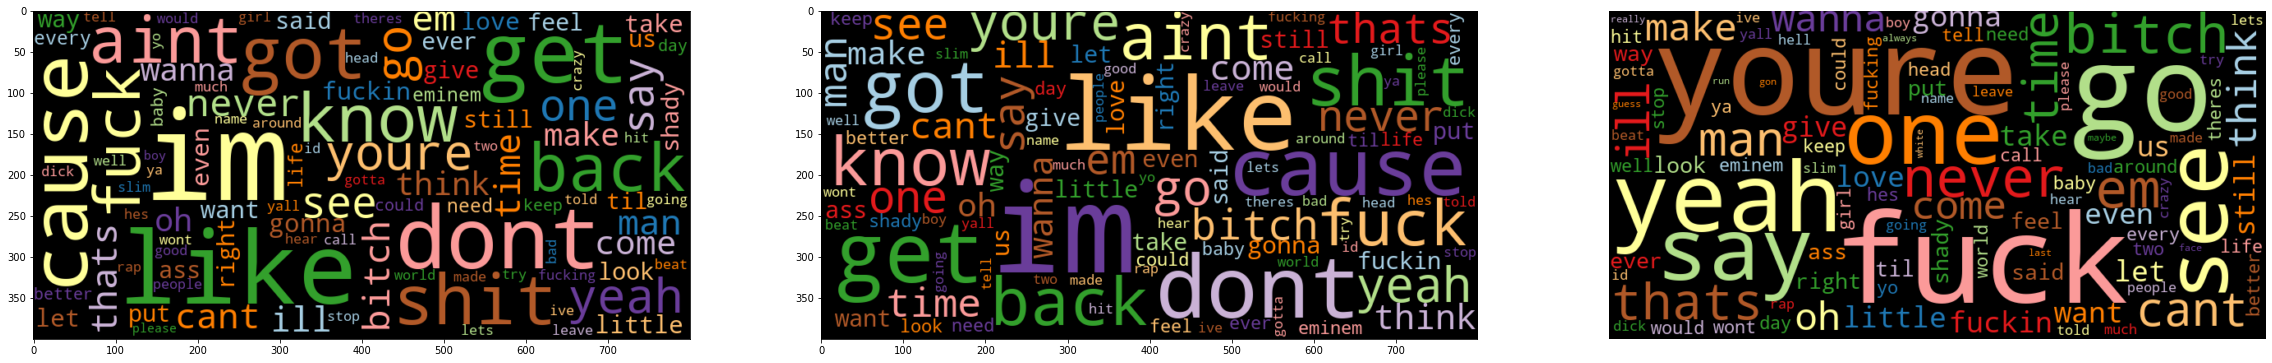

In [285]:
vh_freq_df = count_words(lyrics_data[lyrics_data['artist'] == 'eminem'])

fig, ax = plt.subplots(1, 3, figsize=(40, 30))

wordcloud(vh_freq_df['freq'], max_words=100, ax=ax[0])
wordcloud(vh_freq_df['freq'], max_words=100, stopwords=sw, ax=ax[1])
wordcloud(vh_freq_df['freq'], max_words=100, stopwords=vh_freq_df.head(10).index, ax=ax[2])

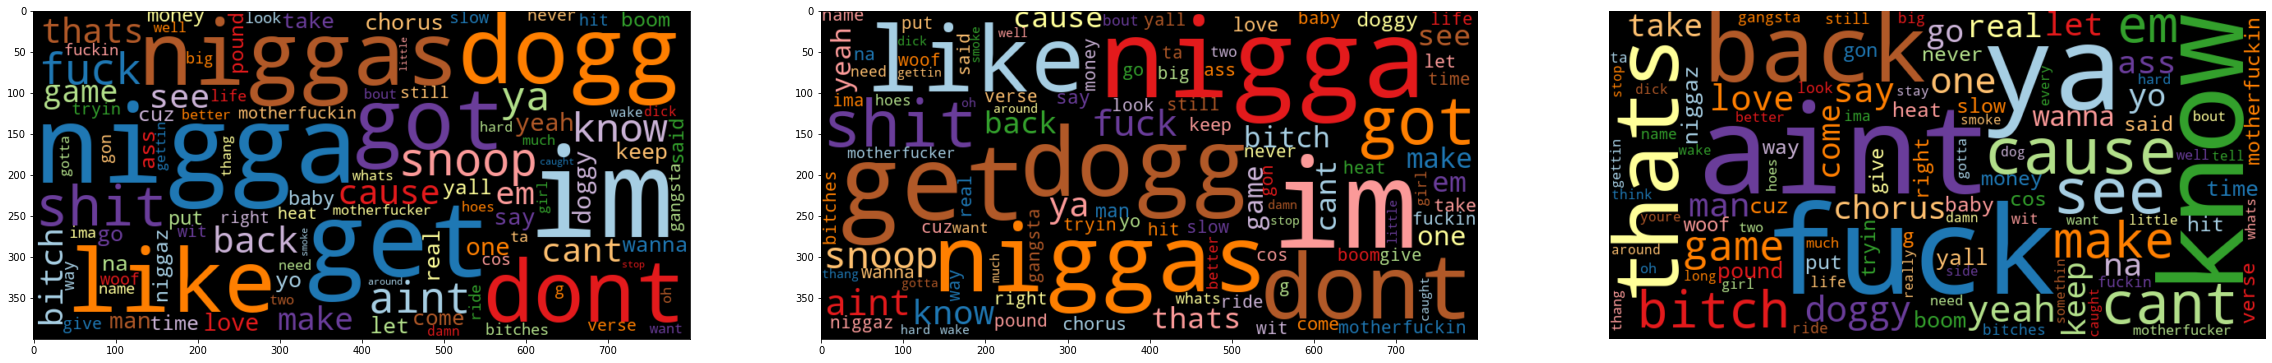

In [286]:
vh_freq_df = count_words(lyrics_data[lyrics_data['artist'] == 'snoop'])

fig, ax = plt.subplots(1, 3, figsize=(40, 30))

wordcloud(vh_freq_df['freq'], max_words=100, ax=ax[0])
wordcloud(vh_freq_df['freq'], max_words=100, stopwords=sw, ax=ax[1])
wordcloud(vh_freq_df['freq'], max_words=100, stopwords=vh_freq_df.head(10).index, ax=ax[2])

Wordcloud for Tweets

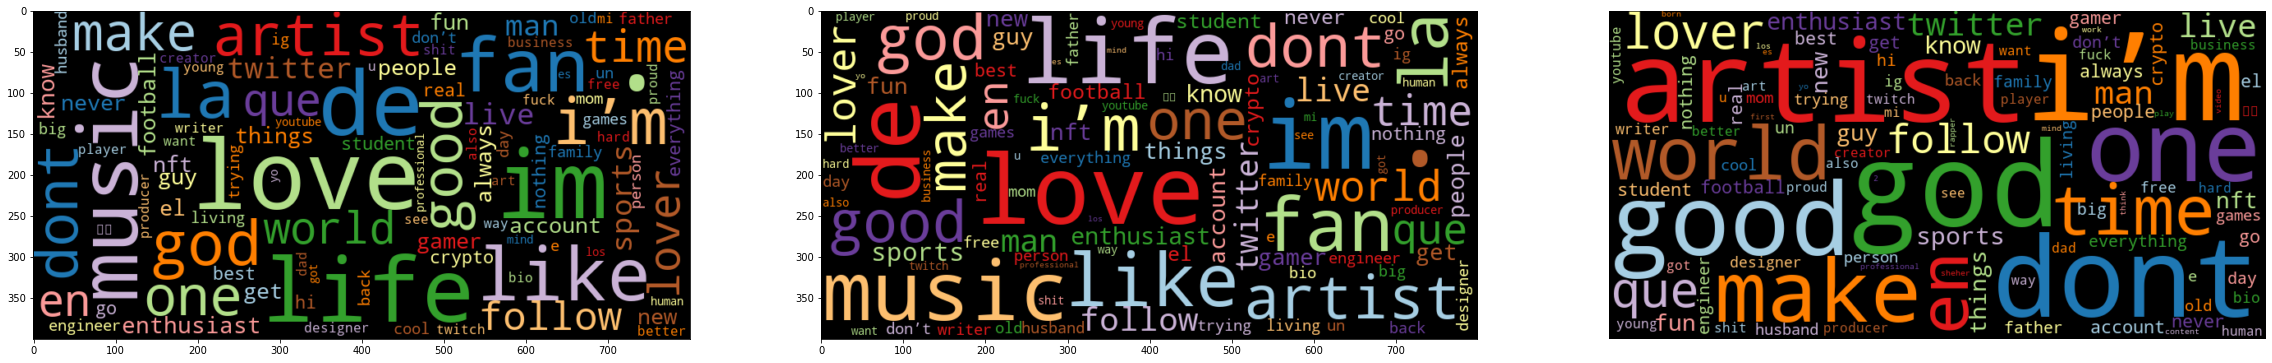

In [290]:
vh_freq_df = count_words(twitter_data[twitter_data['artist'] == 'eminem'])

fig, ax = plt.subplots(1, 3, figsize=(40, 30))

wordcloud(vh_freq_df['freq'], max_words=100, ax=ax[0])
wordcloud(vh_freq_df['freq'], max_words=100, stopwords=sw, ax=ax[1])
wordcloud(vh_freq_df['freq'], max_words=100, stopwords=vh_freq_df.head(10).index, ax=ax[2])

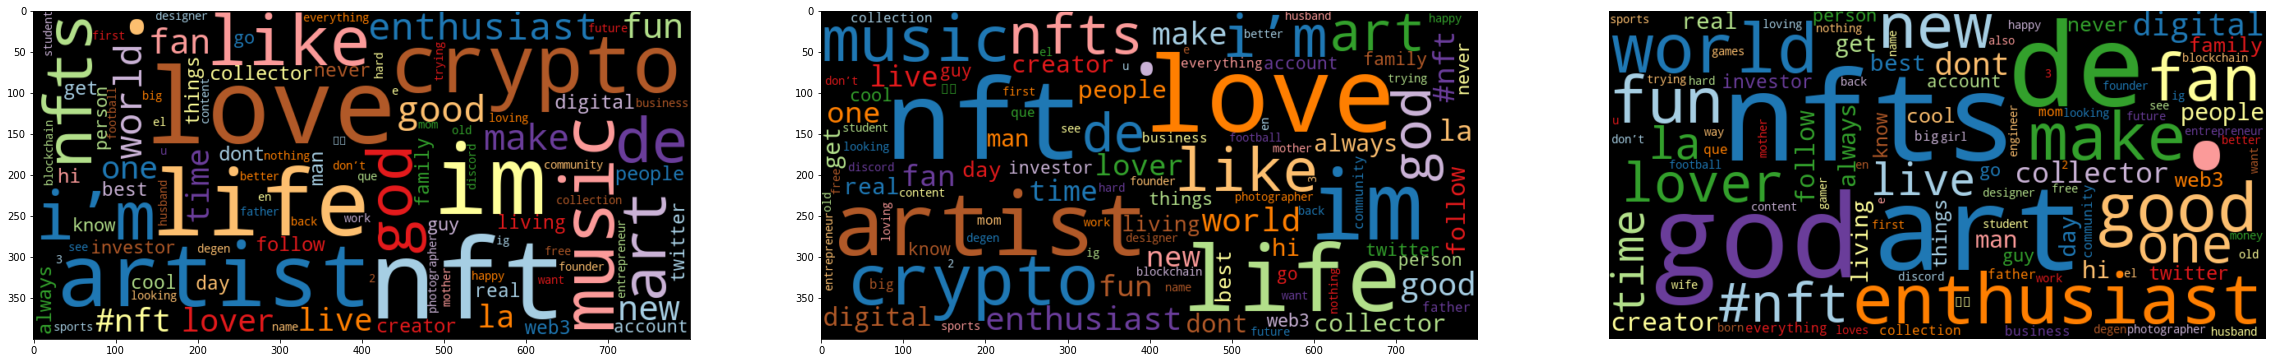

In [289]:
vh_freq_df = count_words(twitter_data[twitter_data['artist'] == 'snoop'])

fig, ax = plt.subplots(1, 3, figsize=(40, 30))

wordcloud(vh_freq_df['freq'], max_words=100, ax=ax[0])
wordcloud(vh_freq_df['freq'], max_words=100, stopwords=sw, ax=ax[1])
wordcloud(vh_freq_df['freq'], max_words=100, stopwords=vh_freq_df.head(10).index, ax=ax[2])

Q: What observations do you have about these (relatively straightforward) wordclouds? 

A: It is very very interesting to see how Snoopdogg puts words in his lyrics. 

For tweets, seems that they both have some things in common like "love" or "god". One big difference that's easy to notice is that Snoop seems to be into an NFTs whereas Enimen is more into "artist". 

For lyrics, as quite expected, they are in favor of cursing words as their genre is in rap that so many words appear in both and are shared commonly. 


It's easy to grasp the overall keywords using wordcloud as shown above.